# LEE（局部线性嵌入）
-> LLE的降维算法属于“流行”降维。在低维空间可以表示高维空间的形状 \
-> 保留局部分点簇之间的相对关系 \
(1) 高纬样本点$X_i$，由它的k个临近点近似，其上标（k）表示k个临近点${X_i^{(k)}}$,$X_i^{(k)} \in [k,D]$ \
(2) 为每个样本点计算一组权重${w_i} \in [1,k]$可以借助这组权重，用$X_i^{(k)}$重构$X_i$ \
${w_i} = \frac{{I_{k \times 1}^{\rm{T}}S_i^{ - 1}}}{{I_{k \times 1}^{\rm{T}}S_i^{ - 1}{I_{k \times 1}}}}$ \
${S_i} = (I_{k \times 1}^{\rm{T}}{X_i} - X_i^{(k)}){(I_{k \times 1}^{\rm{T}}{X_i} - X_i^{(k)})^T}$ \
(3) 将${w_i} \in [1, k]$，扩充为${W_i} \in [1,N]$，k个临近点的位置，$W_{ik}=w_{ik}$，其他位置为0收集N个$W_i$，组成W\
$C = {({I_{N \times N}} - W)^T}({I_{N \times N}} - W)$\
对C进行特征值分解，选取除最小特征值外，最小的d个特征值所对应的特征向量，$Y \in [N,d]$
就是降维后的特征点

In [1]:
# 导包
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.datasets import make_s_curve 
from sklearn.manifold import Isomap 
from tqdm import tqdm
from sklearn.manifold import LocallyLinearEmbedding 

In [2]:
# x 维度 [N, D] 
def cal_pairwise_dist(x): 
    N, D = np.shape(x) 
    dist = np.zeros([N, N])
    for i in range(N): 
        for j in range(N): 
            dist[i, j] = np.sqrt(np.dot((x[i] - x[j]),(x[i] - x[j]).T))
    # 返回任意两个点之间的距离
    return dist

In [3]:
# 获取每个样本点的 n_neighbors个临近点的位置
def get_n_neighbors(data, n_neighbors = 10): 
    dist = cal_pairwise_dist(data)
    dist[dist < 0] = 0
    N = dist.shape[0]
    Index = np.argsort(dist, axis = 1)[:,1:n_neighbors + 1]
    return Index

In [4]:
# 绘制3D图
def scatter_3d(X, y): 
    fig = plt.figure()
    ax = plt.axes( projection = '3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = y, cmap = plt.cm.hot)
    ax.view_init(10, -70)
    ax.set_xlabel("$x_1$", fontsize = 18)
    ax.set_ylabel("$x_2$", fontsize = 18)
    ax.set_zlabel("$x_3$", fontsize = 18)
    plt.show(block = False)

In [5]:
#data : N, D 
def lle(data, n_dims = 2, n_neighbors = 10): 
    N, D = np.shape(data)
    if n_neighbors > D:
        tol = 1e-3
    else: 
        tol = 0 
    # 获取n_neighbors 个临近点的位置
    Index_NN = get_n_neighbors(data, n_neighbors)
    # 计算重构权重
    w = np.zeros([N, n_neighbors])
    for i in range(N): 
        X_k = data[Index_NN[i]] # [K, D]
        X_i = [data[i]] # [1, D]
        I = np.ones([n_neighbors, 1])
        Si = np.dot((np.dot(I, X_i) - X_k), (np.dot(I, X_i) - X_k).T)
        # 未防止对角线元素过小
        Si = Si + np.eye(n_neighbors)*tol*np.trace(Si)
        Si_inv = np.linalg.pinv(Si)
        w[i] = np.dot(I.T, Si_inv)/(np.dot(np.dot(I.T, Si_inv), I))
    # 计算 W
    W = np.zeros([N, N])
    for i in range(N): 
        W[i, Index_NN[i]] = w[i] 
    I_N = np.eye(N) 
    C = np.dot((I_N - W).T, (I_N - W))
    # 进行特征值的分解
    eig_val, eig_vector = np.linalg.eig(C) 
    index_ = np.argsort(eig_val)[1: n_dims + 1] 
    y = eig_vector[:, index_]
    return y

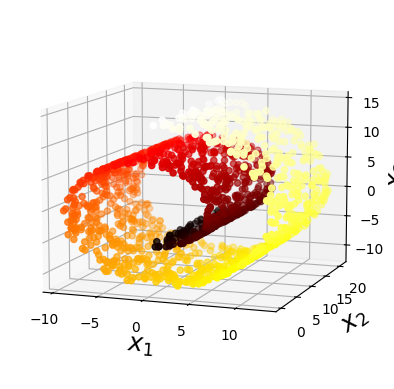

(1500, 2)


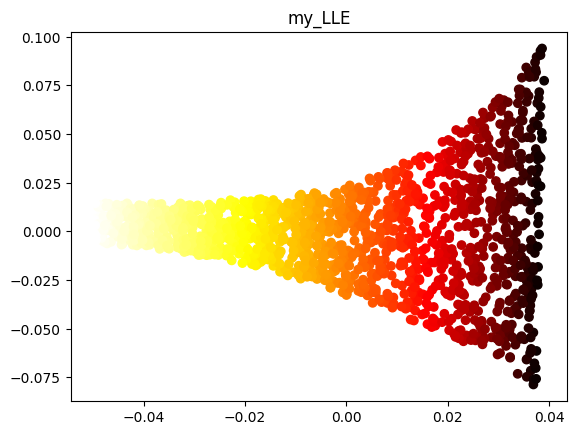

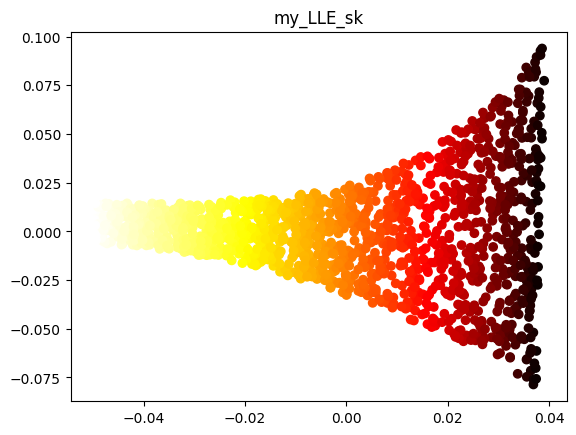

In [6]:
# test
from sklearn.datasets import make_swiss_roll
X, Y = make_swiss_roll(n_samples = 1500)
scatter_3d(X, Y)

data_2d = lle(X, n_dims = 2, n_neighbors = 12)
print(data_2d.shape)
plt.figure()
plt.title("my_LLE")
plt.scatter(data_2d[:, 0], data_2d[:, 1], c = Y, cmap = plt.cm.hot) 
plt.show()
data_2d_sk = LocallyLinearEmbedding(n_components = 2, n_neighbors = 12).fit_transform(X)
plt.figure()
plt.title("my_LLE_sk")
plt.scatter(data_2d[:, 0], data_2d[:, 1], c = Y, cmap = plt.cm.hot) 
plt.show()